# Notes

* Diffusion-QL: boosts the performance of offline RL by representing a policy with a diffusion model, whose success relies on a parameterized Markov Chain with hundreds of steps for sampling.
    - Challenges
    - 1. It is computationally inefficient to forward and backward through the whole Markov chain during training. 
    - 2. It is incompatible with maximum likelihood based RL algorithms (policy gradient methods) as the likelihood of diffusion models is intratable. 

* Offline RL is much desired in real-world applications as it can extract knowledge from previous experiences, thus avoiding costly or risky online interactions. 
* Existing methods mainly focus on addressing this issue by constraining a policy to stay close to the data-collecting policy, making conservative updates for Q-networks, or combining these two strategies. 
* Offline RL can also be viewed as a state-conditional generative modeling problem of actions, where the parameterization of the policy network is iportatnt but largely overlooked. 
* Most offline RL works follow the convention of parameterizing the policy as a diagonal Guassian distribution with the learned mean and variance. This scheme become inferior when the data distribution is complex, especially when offline data are collected from various sources and present strong multi-modalities. 

* Diffusion-QL: replace the diagonal Guassian policy with a diffusion model, significantly boosting the performance of the TD3+BC algorithm. Diffusion models have achieved the new state-of-the-art (SOTA) in image generation tasks, demonstrating a superior ability to capture complex data distributions. 

* Diffusion policy is incompatible with a large family of policy gradient algorithms, which require a tractable and differentiable log-likelihood for policy improvement. 

* Efficient diffusion policy (EDP). 
    - base EDP on the denoising diffusion probabilistic model (DDPM), which learns a noise-prediction network to predict the noise used to corrupt an example. In the forward diffusion process, a corrupted sample follows a predefined Gaussian distribution when the clean example and timestep are given. In turn, given a corrupted sample and predicted noise, we can approximate its clean version by leveraging the reparameterization trick. 
    - we propose action approximation to build an action from a corrupted one, which can be easily constructed from the dataset. In this way, each training step only needs to pass through the noise-prediction network once, thus substantially reducing the training time. 
    - Finally, to support likelihood-based RL algorithms, we leverage the evidence lower bound for the likelihood developed in DDPM and approixmate the policy likelihood from a constructed Gaussian distribution with variance fixed and mean obtained from action approximation. 

* Offline RL:

    - Distributional shift between the learned and behavior policies is offline RL's biggest challenge. 
    - Distributional shift refers to the difference between the data used to train a model (learned policy) and the data encountered when the model is deployed (behavior policy). 
    
* Policy Parameterization:
    - two categories of requirements: 1. The sampling process is differentiable, such as the deterministic policy in DDPG and TD3; 2. The log-likelihood of samples is tractable. 
    

* Contribution
    - first propose a more efficient way to train diffusion policies, which reduces training time to the level of a Guassian policy. 
    - Then, generalize the diffusion policy to be compatible with MLE-based RL methods

## Diffusion models

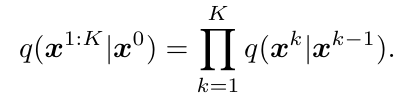
* The equation describes a forward diffusion process applied to a sample x0 drawn from a real data distribution q(x)
* q(x^{1:K|x^0}): this represents the probability distribution of the sequence of noisy samples given the initial sample x0

* second part: this is the product of ocnditional probabilities of each noisy sample x^k given the previous sample x^(k-1). it indicates that the noisy samples are generated step-by-step in a Markov chain, where each step depends only on the previous step. 

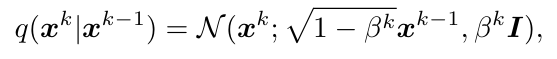
* the foward diffusion process gradually adds gaussian noise to the sample in  steps. the noise added at each step is controlled by a variance schedule

* The noisy sample x^k is drawn from a normal distribution centered around $\sqrt{1-\beta_k}x^{k-1}$ with variance $\beta_k$


### Diffusion Process and Sample Generation

When $K \to \infty$, the noisy sample $x^K$ approaches an isotropic Gaussian distribution. This means that as the number of steps $K$ increases, the final noisy sample $ x^K $ becomes a sample from a standard normal distribution.

### Learning and Reversing the Diffusion Process

Diffusion models learn a conditional distribution $p_\theta(x^{k-1}|x^k) $ to generate new samples by reversing the diffusion process. The reverse process is described by:

$$ p_\theta(x^{0:K}) = p(x^K) \prod_{k=1}^K p_\theta(x^{k-1}|x^k) $$

This equation represents the probability distribution of the sequence of samples $ x^{0:K} $ generated by the reverse process. Here:

- **$ p(x^K) $**: This is the initial distribution of the final noisy sample $ x^K $, which is a standard normal distribution $ \mathcal{N}(0, I) $.

- **$ \prod_{k=1}^K p_\theta(x^{k-1}|x^k) $**: This is the product of the learned conditional probabilities for each step in the reverse process.

### Conditional Distribution in the Reverse Process

The conditional distribution $ p_\theta(x^{k-1}|x^k) $ is modeled as a normal distribution:

$$ p_\theta(x^{k-1}|x^k) = \mathcal{N}(x^{k-1}; \mu_\theta(x^k, k), \Sigma_\theta(x^k, k)) $$

Here:

- **$ \mu_\theta(x^k, k) $**: This is the mean of the normal distribution, which is a function of the noisy sample $ x^k $ and the timestep $ k $.

- **$ \Sigma_\theta(x^k, k) $**: This is the covariance matrix of the normal distribution, also a function of $( x^k )$ and $( k )$.

### Training Objective

The training of the diffusion model is performed by maximizing the evidence lower bound (ELBO):

$$ \mathbb{E}_{q_0}[ \log p_{\theta}(x^{0:K}) ] = \mathbb{E}_{q} \left[ \log \frac{p_{\theta}(x^{0:K})}{q(x^{1:K}|x_0)} \right] $$

This objective aims to maximize the likelihood of the generated samples $x^{0:K}$ under the learned model $ p_\theta$, compared to the true distribution $ q $.

In summary, this part explains how diffusion models generate new samples by reversing the diffusion process and how they are trained to maximize the likelihood of the generated samples.
